In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import trapezoid
from multiprocessing import pool
import multiprocessing as mp
import emcee
from getdist import MCSamples, plots
import matplotlib.pyplot as plt

In [2]:
# =========================
# Leitura dos dados DESI BAO DR2
# =========================

# caminhos
bao_dat_path = "/home/brunowesley/projetos/MCMC-cosmo/Data/BAO/desi_gaussian_bao_ALL_GCcomb_mean.txt"
bao_cov_path = "/home/brunowesley/projetos/MCMC-cosmo/Data/BAO/desi_gaussian_bao_ALL_GCcomb_cov.txt"

# tabela
df_bao = pd.read_csv(bao_dat_path, sep=r"\s+", comment="#", names=["z", "value", "quantity"])

# carregar covariancia
cov_bao = np.loadtxt(bao_cov_path)

# colunas z_bao e d_obs
z_bao = df_bao["z"].values
d_obs = df_bao["value"].values

# cálculo da matriz inversa
Cinv_bao = np.linalg.inv(cov_bao)

In [3]:
# =========================
# Fiducial
# =========================

# Priors uniformes
H0_min, H0_max = 50., 90.
Om0_min, Om0_max = 0.1, 0.6

# Prios gaussianos
mu_Ob, sigma_Ob = 0.0495, 0.0025

# Constantes físicas
c_kms = 299792.458

# Parâmetros cosmológicos
Or0 = 7.88e-5
Neff = 3.04

# Grade
z_grid = np.linspace(0,2.5,1000)

In [4]:
# ==============================
# Funções de Hubble
# ==============================

def E_LCDM(z, Om0):
    Om = Om0 * (1 + z)**3
    Or = Or0 * (1 + z)**4
    Ol0 = 1 - Om0 - Or0
    return np.sqrt(Om + Or + Ol0)

def H_LCDM(z, H0, Om0):
    return H0 * E_LCDM(z, Om0)

In [5]:
# ==============================
# Funções BAO
# ==============================

# Distância comóvel
def comoving_dist(z, H0, Om0):
    z_samples = np.linspace(0, z, 1000)
    y = 1.0 / E_LCDM(z_samples, Om0)
    integral = trapezoid(y, z_samples)
    return (c_kms / H0) * integral

# DM/rd
def DM_over_rd(z, H0, Om0, Ob):
    h2 = (H0 / 100)**2
    Obh2 = Ob * h2
    Omh2 = Om0 * h2
    rd = 147.05 * ((Obh2/0.02236 )**-0.13) * ((Omh2/0.1432)**-0.23) * ((Neff/3.04)**-0.1)
    dC = comoving_dist(z, H0, Om0)
    return dC / rd 

# DH/rd
def DH_over_rd(z, H0, Om0, Ob):
    h2 = (H0 / 100)**2
    Obh2 = Ob * h2
    Omh2 = Om0 * h2
    rd = 147.05 * ((Obh2/0.02236 )**-0.13) * ((Omh2/0.1432)**-0.23) * ((Neff/3.04)**-0.1)
    H_theo = H_LCDM(z, H0, Om0)
    return c_kms / (rd * H_theo)

# DV/rd
def DV_over_rd(z, H0, Om0, Ob):
    dm = DM_over_rd(z, H0, Om0, Ob)
    dh = DH_over_rd(z, H0, Om0, Ob)
    return (z * dm**2 * dh)**(1/3)


# ==============================
# Vetor BAO teórico
# ==============================
def d_LCDM(z, H0, Om0, Ob):

    d_model = []

    for _, row in df_bao.iterrows():
        z = row["z"]
        q = row["quantity"]

        if q == "DV_over_rs":
            d = DV_over_rd(z, H0, Om0, Ob)

        elif q == "DM_over_rs":
            d = DM_over_rd(z, H0, Om0, Ob)

        elif q == "DH_over_rs":
            d = DH_over_rd(z, H0, Om0, Ob)

        else:
            raise ValueError(f"Observavel BAO desconhecido: {q}")

        d_model.append(d)

    return np.array(d_model)

print(d_LCDM(z_bao, 70, 0.3, 0.0495))

[ 7.91976415 13.28342599 22.49262762 17.44426444 20.00919635 21.71007652
 17.47577669 27.77430275 14.03234432 29.96414452 12.86138737  8.62496113
 38.87042262]


In [6]:
# =========================================
# Likelihood DESI BAO DR2
# =========================================

# Priors
def lnprior_bao(theta_bao):
    H0, Om0, Ob = theta_bao
    
    # priors planos
    if not (H0_min < H0 < H0_max):     return -np.inf
    if not (Om0_min < Om0 < Om0_max):  return -np.inf

    # prior gaussiano em Omega_b
    lp_Ob = -0.5 * ((Ob - mu_Ob)**2 / sigma_Ob**2) - np.log(sigma_Ob * np.sqrt(2*np.pi))
    return lp_Ob


# Likelihood
def lnlike_bao(theta_bao, z_bao, d_obs, Cinv_bao):
    H0, Om0, Ob = theta_bao
    d_model = d_LCDM(z_bao, H0, Om0, Ob)
    delta = d_obs - d_model
    chi2_bao = np.dot(delta, np.dot(Cinv_bao, delta))
    return -0.5 * chi2_bao


# Posteriori
def lnprob_bao(theta_bao, z_bao, d_obs, Cinv_bao):
    lp = lnprior_bao(theta_bao)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_bao(theta_bao, z_bao, d_obs, Cinv_bao)


# Teste rápido
theta_bao_test = [70, 0.3, 0.0495]
print(lnprob_bao(theta_bao_test, z_bao, d_obs, Cinv_bao))

-0.16847254446595006


In [ ]:
# =========================
# MCMC
# =========================

ndim, nwalkers, nsteps, nburn = 3, 40, 53500, 3500
rng = np.random.default_rng(42)

p0 = np.zeros((nwalkers, ndim))
p0[:,0] = rng.uniform(H0_min, H0_max, size=nwalkers)         # H0 uniforme
p0[:,1] = rng.uniform(Om0_min, Om0_max, size=nwalkers)       # Omega_m0 uniforme
p0[:,2] = rng.normal(mu_Ob, sigma_Ob, nwalkers)              # Ob gaussiano

# Paralelizando a criação das cadeias (MAIS eficiente para LCDM_BAO)
with mp.Pool(processes=40) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_bao, args=(z_bao, d_obs, Cinv_bao), pool=pool)
    sampler.run_mcmc(p0, nsteps, progress=True)

# Criação das cadeias usando single-threaded (MENOS eficiente para LCDM_BAO)
# sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_bao, args=(z_bao, d_obs, Cinv_bao))
# sampler.run_mcmc(p0, nsteps, progress=True)

# Cadeia completa: shape (nsteps, nwalkers, ndim)
chain = sampler.get_chain()
# np.save("chain_LCDM_bao.npy", chain)

# Cadeia "achatada" (flat) após burn-in: shape (N_total, ndim)
flat_samples = sampler.get_chain(discard=nburn, flat=True)
np.save("flat_samples_LCDM_bao.npy", flat_samples)

100%|██████████| 53500/53500 [02:57<00:00, 301.19it/s]


Removed no burn in


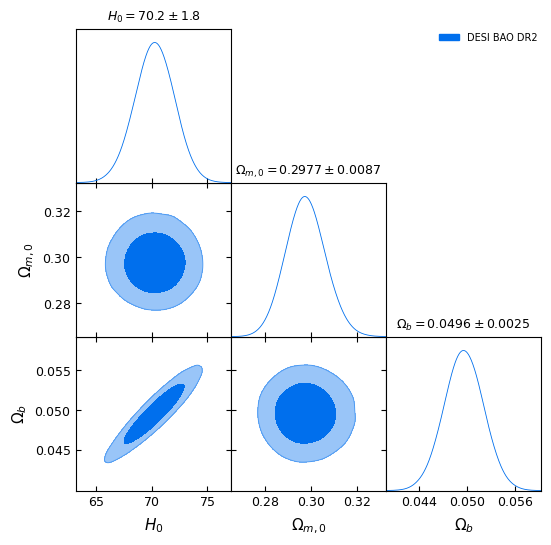

In [8]:
# =========================
# GetDist
# =========================

param_names  = ["H0", "Omega_m0", "Omega_b"]
param_labels = [r"H_0", r"\Omega_{m,0}", r"\Omega_b"]

samples = MCSamples(
    samples=flat_samples,
    names=param_names,
    labels=param_labels
)

samples.updateSettings({
    "smooth_scale_1D": 0.25,
    "smooth_scale_2D": 0.25,
    "fine_bins": 1024,
    "fine_bins_2D": 1024

})

# samples.setRanges({
#     "H0": (50, 90),
#     "Omega_m": (0.1, 0.6)
# })

g = plots.get_subplot_plotter()
g.settings.axes_fontsize = 12
g.settings.lab_fontsize = 14
g.settings.legend_fontsize = 10
g.settings.linewidth_contour = 1.2
g.settings.num_plot_contours = 2
g.settings.axis_marker_lw = 1.0
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.3

# Triangle plot
g.triangle_plot(
    samples,
    filled=True,
    legend_labels=["DESI BAO DR2"],
    #contour_colors=["#"],
    title_limit=1
)

plt.savefig("triangle_LCDM_bao.png", dpi=300, bbox_inches="tight")
plt.show()